In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time

### Importing External Libraries

import numpy                             as np
import pandas                            as pd


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')


### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


from scipy.integrate import solve_ivp
import pyDOE
from PCAfold         import PCA          as PCAA

3.9.12 (main, Mar 26 2022, 15:51:13) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


In [2]:
OutputDir   = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/Rect_200Instants_TransRotScale_Empty_Rand/')
FigDir      = os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet_TEMP/')

RandFlg     = True

Nt          = 200
Nx          = 100
Ny          = 100

RotFlg      = True
TransFlg    = True
ScaleFlg    = True

PlotFlg     = False
SaveFlg     = True

ColorVec    = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']

try:
    os.makedirs(OutputDir)
except OSError as e:
    pass

OutputDir += '/Orig/'
try:
    os.makedirs(OutputDir)
except OSError as e:
    pass

TempDir = OutputDir+'/train/'
try:
    os.makedirs(TempDir)
except OSError as e:
    pass

TempDir = TempDir+'/ext/'
try:
    os.makedirs(TempDir)
except OSError as e:
    pass

TempDir = OutputDir+'/test/'
try:
    os.makedirs(TempDir)
except OSError as e:
    pass

TempDir = TempDir+'/ext/'
try:
    os.makedirs(TempDir)
except OSError as e:
    pass

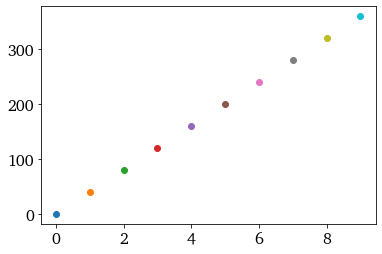

In [3]:
Theta0  = 0./180*np.pi
w_Theta = 36./180*np.pi

tVec    = np.linspace(0.,10.,10)
for it, t in enumerate(tVec):
    Theta = Theta0 + w_Theta*t
    
    plt.plot(it,Theta*180/np.pi,'o')

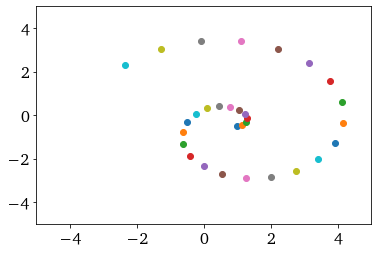

In [4]:
w_Psi = 50./180*np.pi
ca    = 0.5
cx0   = 1.
cy0   = -0.5

tVec    = np.linspace(0.,10.,30)
for it, t in enumerate(tVec):
    Psi   = t*w_Psi
    cr    = ca * Psi
    cx    = cx0 + cr * np.cos(Psi)
    cy    = cy0 + cr * np.sin(Psi)    
    
    plt.plot(cx,cy,'o')
    plt.xlim([-5,5])
    plt.ylim([-5,5])

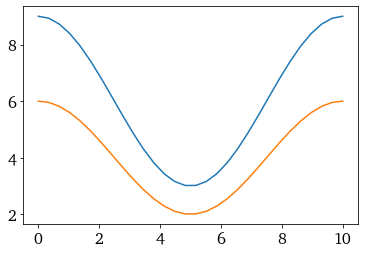

In [5]:
lx0   = 3.
ly0   = 2.

tEnd    = 10.
tVec    = np.linspace(0.,tEnd,30)
lx    = (np.cos(tVec/tEnd*360. / 180.*np.pi)+2)*lx0
ly    = (np.cos(tVec/tEnd*360. / 180.*np.pi)+2)*ly0
    
plt.plot(tVec,lx)
plt.plot(tVec,ly)

In [6]:
v_zz  = 0.2
zz0   = 1.

tVec    = np.linspace(0.,10.,30)
for it, t in enumerate(tVec):
    zz  = zz0 + t*v_zz

In [7]:
xMin    = -10.
xMax    = 10.
yMin    = -10.
yMax    = 10.

t0      = 0.
tEnd    = 10.

if (PlotFlg):
    tVec = np.linspace(0,10,10)
else:
    tVec = np.linspace(t0,tEnd,Nt)
XX       = np.zeros((Nx*Ny,Nt))
jt       = 0
for it, t in enumerate(tVec):
    if (t < 4.5 or t > 5.5):
        print('it=', it, '; t=',t)

        if (RotFlg == True):
            Theta = Theta0 + w_Theta*t
        else:
            Theta = Theta0

        if (TransFlg == True):
            Psi   = t*w_Psi
            cr    = ca * Psi
            cx    = cx0 + cr * np.cos(Psi)
            cy    = cy0 + cr * np.sin(Psi)  
        else:
            cx    = 0.
            cy    = 0.

        if (ScaleFlg == True):
            lx    = (np.cos(t/tEnd*360. / 180.*np.pi)+2.)*lx0
            ly    = (np.cos(t/tEnd*360. / 180.*np.pi)+2.)*ly0
        else:
            lx    = lx0*2 
            ly    = ly0*2 

        zz    = zz0 + t*v_zz


        II_  = np.zeros((Nx*Ny,2))
        TT_  = np.zeros((Nx*Ny,1))
        OO_  = np.zeros((Nx*Ny,1))
        Mat  = np.zeros((Nx,Ny))

        if (not RandFlg):
            x    = np.linspace(xMin,xMax,Nx)
            y    = np.linspace(yMin,yMax,Ny)

            i    = 0
            for ix, x_ in enumerate(x):
                for iy, y_ in enumerate(y):
                    xrot_      = x_*np.cos(Theta) + y_*np.sin(Theta)
                    yrot_      = x_*np.sin(Theta) - y_*np.cos(Theta)
                    zx         = np.tanh((xrot_-cx+lx/2)*10.) - np.tanh((xrot_-cx-lx/2)*10.)
                    zy         = np.tanh((yrot_-cy+ly/2)*10.) - np.tanh((yrot_-cy-ly/2)*10.)  
                    II_[i,0]   = x_
                    II_[i,1]   = y_
                    TT_[i,0]   = t
                    OO_[i,0]   = np.exp(zx+zy)*zz
                    Mat[ix,iy] = np.exp(zx+zy)*zz
                    XX[i,it]   = np.exp(zx+zy)*zz

                    i+=1

        else:
            xy      = np.random.rand(Nx*Ny,2)
            xy[:,0] = xy[:,0]*(xMax-xMin) + xMin
            xy[:,1] = xy[:,1]*(yMax-yMin) + yMin

            for i in range(Nx*Ny):
                x_         = xy[i,0]
                y_         = xy[i,1]
                xrot_      = x_*np.cos(Theta) + y_*np.sin(Theta)
                yrot_      = x_*np.sin(Theta) - y_*np.cos(Theta)
                zx         = np.tanh((xrot_-cx+lx/2)*10.) - np.tanh((xrot_-cx-lx/2)*10.)
                zy         = np.tanh((yrot_-cy+ly/2)*10.) - np.tanh((yrot_-cy-ly/2)*10.)  
                II_[i,0]   = x_
                II_[i,1]   = y_
                TT_[i,0]   = t
                OO_[i,0]   = np.exp(zx+zy)*zz
                XX[i,it]   = np.exp(zx+zy)*zz

        if (it==0):
            II = II_
            OO = OO_
            TT = TT_
        else:
            II = np.concatenate([II,II_], axis=0)
            TT = np.concatenate([TT,TT_], axis=0)
            OO = np.concatenate([OO,OO_], axis=0)

        if (PlotFlg):
            plt.figure()
            plt.imshow(Mat)
            
        jt += 1

it= 0 ; t= 0.0
it= 1 ; t= 0.05025125628140704
it= 2 ; t= 0.10050251256281408
it= 3 ; t= 0.15075376884422112
it= 4 ; t= 0.20100502512562815
it= 5 ; t= 0.2512562814070352
it= 6 ; t= 0.30150753768844224
it= 7 ; t= 0.35175879396984927
it= 8 ; t= 0.4020100502512563
it= 9 ; t= 0.45226130653266333
it= 10 ; t= 0.5025125628140704
it= 11 ; t= 0.5527638190954774
it= 12 ; t= 0.6030150753768845
it= 13 ; t= 0.6532663316582915
it= 14 ; t= 0.7035175879396985
it= 15 ; t= 0.7537688442211056
it= 16 ; t= 0.8040201005025126
it= 17 ; t= 0.8542713567839196
it= 18 ; t= 0.9045226130653267
it= 19 ; t= 0.9547738693467337
it= 20 ; t= 1.0050251256281408
it= 21 ; t= 1.0552763819095479
it= 22 ; t= 1.105527638190955
it= 23 ; t= 1.155778894472362
it= 24 ; t= 1.206030150753769
it= 25 ; t= 1.256281407035176
it= 26 ; t= 1.306532663316583
it= 27 ; t= 1.35678391959799
it= 28 ; t= 1.407035175879397
it= 29 ; t= 1.4572864321608041
it= 30 ; t= 1.5075376884422111
it= 31 ; t= 1.5577889447236182
it= 32 ; t= 1.6080402010050252
it=

In [8]:
# n_modes    = 64

# pca        = PCAA(XX, scaling='range', n_components=int(n_modes), nocenter=False)
# C          = pca.X_center
# D          = pca.X_scale
# A          = pca.A[:,0:n_modes].T
# L          = pca.L
# LL         = np.maximum(L,0.)
# AT         = A.T

In [9]:
# plt.plot(L)
# plt.yscale('log')

In [10]:
# XX_pca   = ((XX - C)/D).dot(AT)
# XX_      = (XX_pca.dot(A))*D + C

In [11]:
# it = 1

# plt.figure()
# plt.imshow((XX[:,it-1]).reshape(Nx,Ny))

# plt.figure()
# plt.imshow((XX_[:,it-1]).reshape(Nx,Ny))

# plt.figure()
# plt.imshow((XX[:,it-1]-XX_[:,it-1]).reshape(Nx,Ny))

In [12]:
# plt.plot((XX[:,0]).reshape(Nx,Ny)[100,:])
# plt.plot((XX_[:,0]).reshape(Nx,Ny)[100,:])

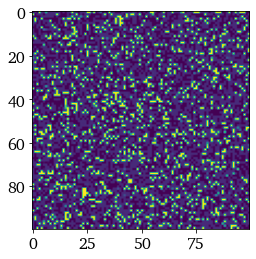

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

img = [] # some array of images
frames = [] # for storing the generated images
fig = plt.figure()
for it in range(XX.shape[1]):
    frames.append([plt.imshow((XX[:,it]).reshape(Nx,Ny),animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=5000, blit=True, repeat_delay=50000)
writergif = animation.PillowWriter(fps=30)
ani.save(OutputDir+'/Video.gif',writer=writergif)

In [14]:
if (SaveFlg):

    
    from sklearn.model_selection import train_test_split

    try:
        os.makedirs(OutputDir+'/valid/')
    except:
        pass


    data_id    = 'pts'

    DataInput  = pd.DataFrame(np.concatenate((TT,II), axis=1), columns=['t','x','y'])
    DataOutput = pd.DataFrame(np.concatenate((TT,OO), axis=1), columns=['t','z'])

    n_points   = len(DataInput)

    idx                  = np.arange(n_points)
    train_idx, valid_idx = train_test_split(idx, test_size=0.2, random_state=42)

    n_valid              = len(valid_idx)
    n_train              = len(train_idx)

    try:
        os.makedirs(OutputDir+'/train/'+data_id+'/')
    except:
        pass
    try:
        os.makedirs(OutputDir+'/valid/'+data_id+'/')
    except:
        pass

    DataInput.iloc[train_idx].to_csv(OutputDir+'/train/'+data_id+'/Input.csv', index=False)
    DataInput.iloc[valid_idx].to_csv(OutputDir+'/valid/'+data_id+'/Input.csv', index=False)

    DataOutput.iloc[train_idx].to_csv(OutputDir+'/train/'+data_id+'/Output.csv', index=False)
    DataOutput.iloc[valid_idx].to_csv(OutputDir+'/valid/'+data_id+'/Output.csv', index=False)